# FashionMNIST - CNN Classification Project
Data Source: <a href='https://www.kaggle.com/zalando-research/fashionmnist'>Fashion-MNIST</a> dataset, also available through torchvision. 

Dataset consists of a training set of 60,000 examples and a test set of 10,000 examples.

Each example is a 28x28 grayscale image, associated with a label from 10 classes:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

The goal of this notebook is to demonstrate my understanding of CNNs and showcase how this code can be a framework to be built upon for future CNN projects

## Imports & Installs

This notebook was created in Databricks so I had to pip install torch and torch vision each time the serverless compute timed out

In [0]:
pip install torch

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
pip install torchvision

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms    
# Could also import models if I wanted to do some transfer learning with a pretrained model
from torchvision.utils import make_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Data Ingest

In [0]:
# Doing some data augmentation to artificially increase size of dataset and force the model to learn invariances
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(root='data/', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data/', train=False, download=True, transform=transform)

class_names = ['T-shirt','Trouser','Sweater','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot']

### Create Data Loaders

In [0]:
batch_size = 10

In [0]:
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

### Look at single batch to verify data ingest

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: [8 1 2 4 9 1 6 0 8 6]
Class:  Bag Trouser Sweater Coat Boot Trouser Shirt T-shirt Bag Shirt


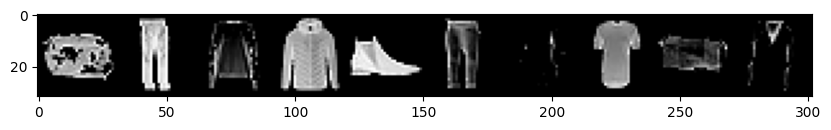

In [0]:
# For-Loop trick to just get 1 batch
for images, labels in train_loader:
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow = 10)
plt.figure(figsize = (10,4))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))


## Define CNN Class

Keeping it simple with 2 convolutional layers and 3 fully connected layers.

Intentionally keeping the architecture shallow to balance learning speed with model capacity since we're only working with 28x28 sized images. Having too deep of a network could risk overfitting.

Using log_softmax instead of softmax because of increased numerical stability & simplification of cross-entropy loss function later on.

Main constraint is to ensure 10 output neurons since we have 10 classes

In [0]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)    # Output is 10 neurons because we have 10 classes

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

Initialize Model and verify architecture

In [0]:
torch.manual_seed(42)
model = ConvolutionalNetwork().to(device)
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Train CNN

In [0]:
# Quick check to see parameter count per layer
for p in model.parameters():
    print(p.numel())

54
6
864
16
48000
120
10080
84
840
10


### Loss Function & Optimizer

In [0]:
# CrossEntropyLoss for Classification
# Adam with a learning rate of 0.001 as a good starting point
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Actual Training

In [0]:
import time
start_time = time.time()

# VARIABLES (TRACKERS - not needed but it's pretty convenient)
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# FOR LOOP EPOCHS
for i in range(epochs):

    model.train()
    trn_corr = 0
    tst_corr = 0

    # TRAIN
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        b += 1

        y_pred = model(X_train) # Note: This isn't flattened! We can keep it 2D which is a pro compared to ANNs
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()   # How many correct in this batch?
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%600 == 0:  # 60,000 training images so this should give us a few printouts per epoch
            print(f'epoch: {i} batch: {b} loss: {loss.item()}')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # TEST
    model.eval()
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_val = model(X_test)

            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())   # I like to do this so I can plot losses in matplotlib inline later
    test_correct.append(tst_corr.item())

# Print out Timing
current_time = time.time()
total_time = current_time - start_time
print(f"Total time: {total_time/60} minutes")


epoch: 0 batch: 600 loss: 0.9827765226364136
epoch: 0 batch: 1200 loss: 0.7611803412437439
epoch: 0 batch: 1800 loss: 0.21321387588977814
epoch: 0 batch: 2400 loss: 0.8353912234306335
epoch: 0 batch: 3000 loss: 0.17862747609615326
epoch: 0 batch: 3600 loss: 0.7110894918441772
epoch: 0 batch: 4200 loss: 0.166108638048172
epoch: 0 batch: 4800 loss: 0.5640754699707031
epoch: 0 batch: 5400 loss: 0.36751389503479004
epoch: 0 batch: 6000 loss: 0.4195650517940521
epoch: 1 batch: 600 loss: 0.6812468767166138
epoch: 1 batch: 1200 loss: 0.7525212168693542
epoch: 1 batch: 1800 loss: 0.9146636128425598
epoch: 1 batch: 2400 loss: 0.5994078516960144
epoch: 1 batch: 3000 loss: 0.4165129065513611
epoch: 1 batch: 3600 loss: 0.6757416725158691
epoch: 1 batch: 4200 loss: 0.5119205713272095
epoch: 1 batch: 4800 loss: 0.056459687650203705
epoch: 1 batch: 5400 loss: 0.1549854427576065
epoch: 1 batch: 6000 loss: 0.3107093274593353
epoch: 2 batch: 600 loss: 0.1880006492137909
epoch: 2 batch: 1200 loss: 0.6629

Save off the model so we can load it next time and bypass training

In [0]:
torch.save(model.state_dict(), 'fashion_mnist_cnn.pt')

## Evaluate CNN

### Look at some loss and accuracy plots

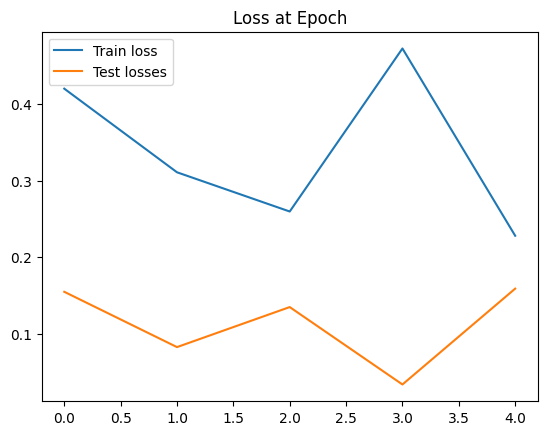

In [0]:
plt.plot(train_losses, label = 'Train loss')
plt.plot(test_losses, label='Test losses')
plt.title('Loss at Epoch')
plt.legend()

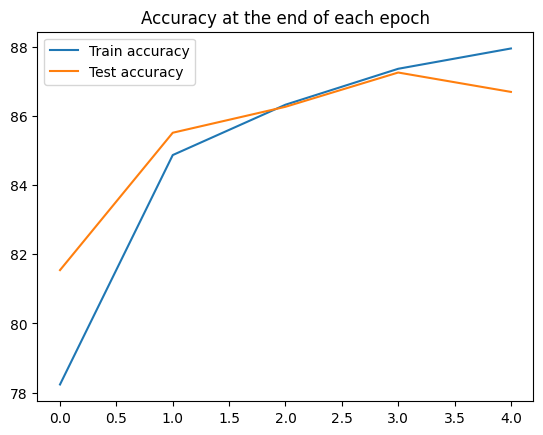

In [0]:
plt.plot([t/600 for t in train_correct], label='Train accuracy')
plt.plot([t/100 for t in test_correct], label='Test accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [0]:
model.eval()

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_loader:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.2f}%')

Test accuracy: 8608/10000 =   86.08%


## Closing Remarks

Using a shallow 2-layer CNN with 5 epochs and light augmentation on FashionMNIST resulted in around 86% accuracy which is a reasonable baseline.

With deeper architectures and better tuning, I'd expect improvement to 92-93% accuracy. There were quite a few limitations with this study:
- Only 5 epochs of training
- No hyperparameter tuning or early stopping

Given more time, I'd run 15-20 epochs with learning rate decay, try a slightly deeper architecture, add dropout before the fully connected layers and compare to a pretrained model like AlexNet